In [1]:
from gym.wrappers import RescaleAction, TimeLimit
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from environments import ARESEAOneStep, ARESEASequential

# Sequential

In [18]:
def plot_examples(run_name, envargs={}, backendargs={}):
    log_dir = f"models/{run_name}"

    def make_env():
        env = ARESEASequential(
            backend="simulation",
            backendargs=backendargs,
            **envargs
        )
        env = TimeLimit(env, max_episode_steps=50)
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = TD3.load(f"{log_dir}/model")

    plt.figure(figsize=(21,4))
    for i in range(3):
        observation = env.reset()
        desired = env.unnormalize_obs(observation)[0,-8:-4]
        initial = env.unnormalize_obs(observation)[0,-4:]
        done = False
        while not done:
            action, _ = model.predict(observation, deterministic=True)
            observation, reward, done, info = env.step(action)
        achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]

        # print(f"{i}: Initial:", initial)
        # print(f"{i}: Achieved:", achieved)
        # print(f"{i}: Desired:", desired)
        # print(f"{i}: Delta:", desired - achieved)
        # print(f"{i}: Objective:", env.unwrapped.envs[0].unwrapped._objective_fn(achieved, desired))

        screen = env.get_attr("backend")[0]._segment.AREABSCR1

        plt.subplot(1, 3, i+1)
        plt.title("Beam Parameters")
        plt.xlim([screen.extent[0], screen.extent[1]])
        plt.ylim([screen.extent[2], screen.extent[3]])
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.grid()
        plt.gca().add_patch(Ellipse((initial[0],initial[1]), initial[2], initial[3], fill=False, color="red", label="Initial"))
        plt.gca().add_patch(Ellipse((achieved[0],achieved[1]), achieved[2], achieved[3], fill=False, color="orange", label="Achieved"))
        plt.gca().add_patch(Ellipse((desired[0],desired[1]), desired[2], desired[3], fill=False, color="green", label="Desired"))
        plt.legend()
    plt.show()

In [23]:
def evaluate(run_name, n=100, envargs={}, backendargs={}):
    log_dir = f"models/{run_name}"

    def make_env():
        env = ARESEASequential(
            backend="simulation",
            backendargs=backendargs,
            **envargs
        )
        env = TimeLimit(env, max_episode_steps=50)
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = TD3.load(f"{log_dir}/model")

    objectives = []
    mses = []
    achieveds = []
    desireds = []
    for _ in range(n):
        observation = env.reset()
        desired = env.unnormalize_obs(observation)[0,-8:-4]
        desireds.append(desired)
        done = False
        while not done:
            action, _ = model.predict(observation, deterministic=True)
            observation, reward, done, info = env.step(action)
        achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]
        achieveds.append(achieved)
        objective = env.unwrapped.envs[0].unwrapped._objective_fn(achieved, desired)
        objectives.append(objective)
        mse = ((desired - achieved)**2).mean()
        mses.append(mse)
    
    return objectives, mses, achieveds, desireds

In [26]:
def run_evaluation(run_names, envargs={}, backendargs={}):
    objectives, mses, _, _ = zip(*(evaluate(run_name, n=300, envargs=envargs, backendargs=backendargs) for run_name in run_names))

    plt.figure(figsize=(18,8))
    for i, (run_name, objective, mse) in enumerate(zip(run_names, objectives, mses)):
        plt.subplot(2, len(run_names), i+1)
        plt.title(run_name)
        sns.histplot(objective, bins=20, kde=True)
        plt.xlabel("Achieved Objective")
        plt.subplot(2, len(run_names), len(run_names)+i+1)
        sns.histplot(mse, bins=20, kde=True)
        plt.xlabel("MSE")
    plt.tight_layout()
    plt.show()

## Default (with refactred environment architecture)

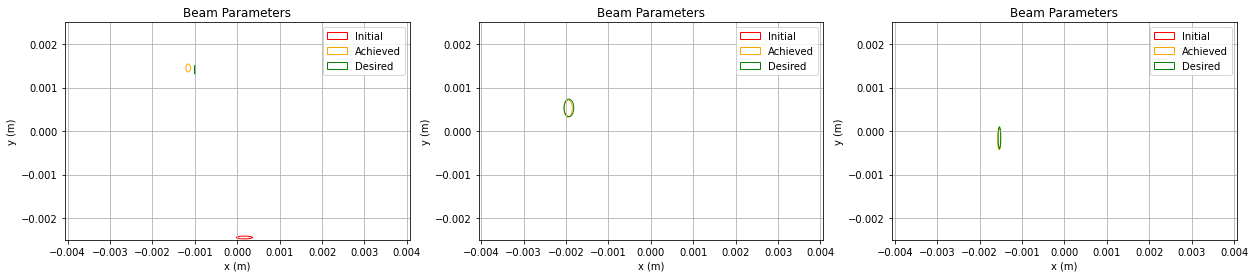

In [28]:
plot_examples(
    "bright-rain-963",
    envargs={"initial": "random"},
    backendargs={"incoming": "random", "beam_parameters": "direct"}
)

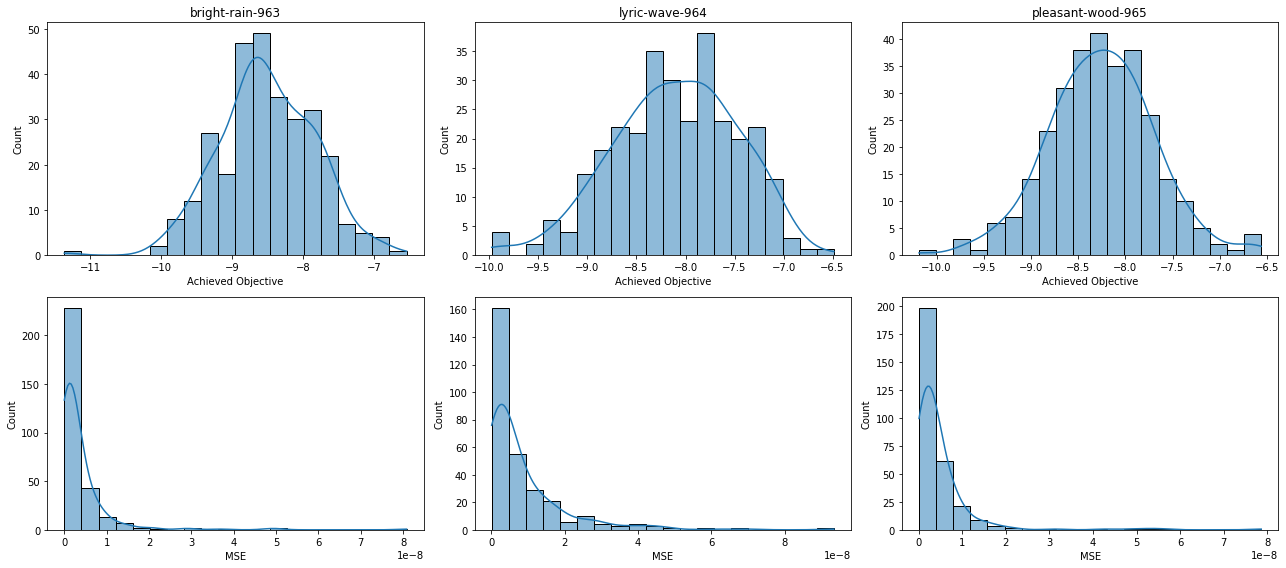

In [29]:
run_evaluation(
    ["bright-rain-963", "lyric-wave-964", "pleasant-wood-965"],
    envargs={"initial": "random"},
    backendargs={"incoming": "random", "beam_parameters": "direct"}
)

## Same initial actuators

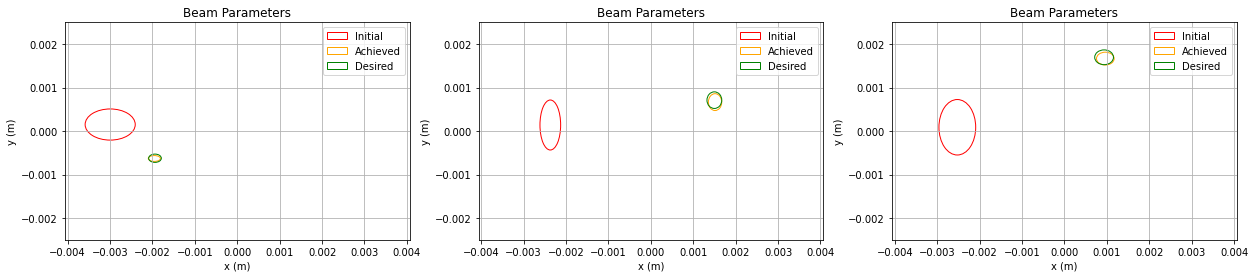

In [25]:
plot_examples(
    "bright-rain-963",
    envargs={"initial": "reset"},
    backendargs={"incoming": "random", "beam_parameters": "direct"}
)

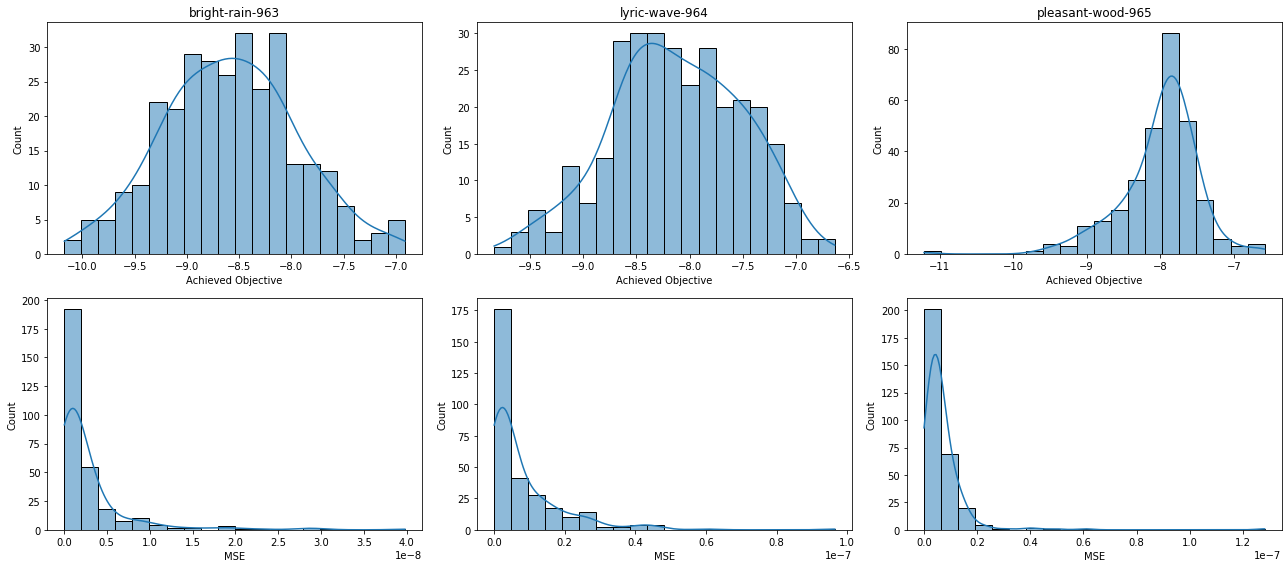

In [27]:
run_evaluation(
    ["bright-rain-963", "lyric-wave-964", "pleasant-wood-965"],
    envargs={"initial": "reset"},
    backendargs={"incoming": "random", "beam_parameters": "direct"}
)

## Quadrupole and Screen Offsets (up to 1 mm both directions)

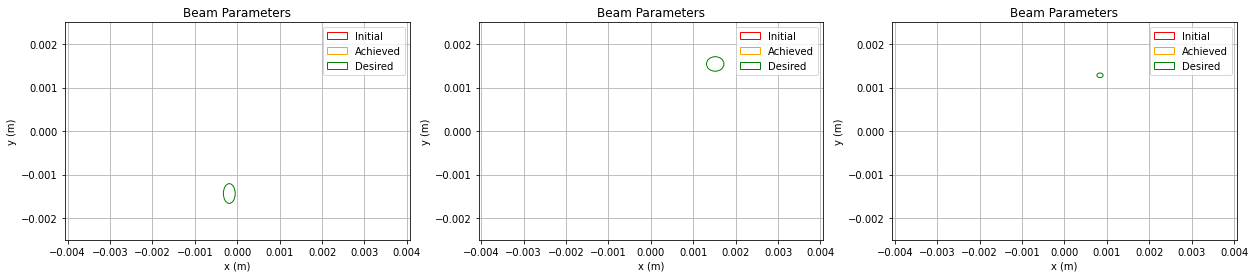

In [30]:
plot_examples(
    "electric-universe-968",
    envargs={"initial": "reset"},
    backendargs={"incoming": "random", "beam_parameters": "direct", "quadrupole_misalignments": "random", "screen_misalignment": "random"}
)

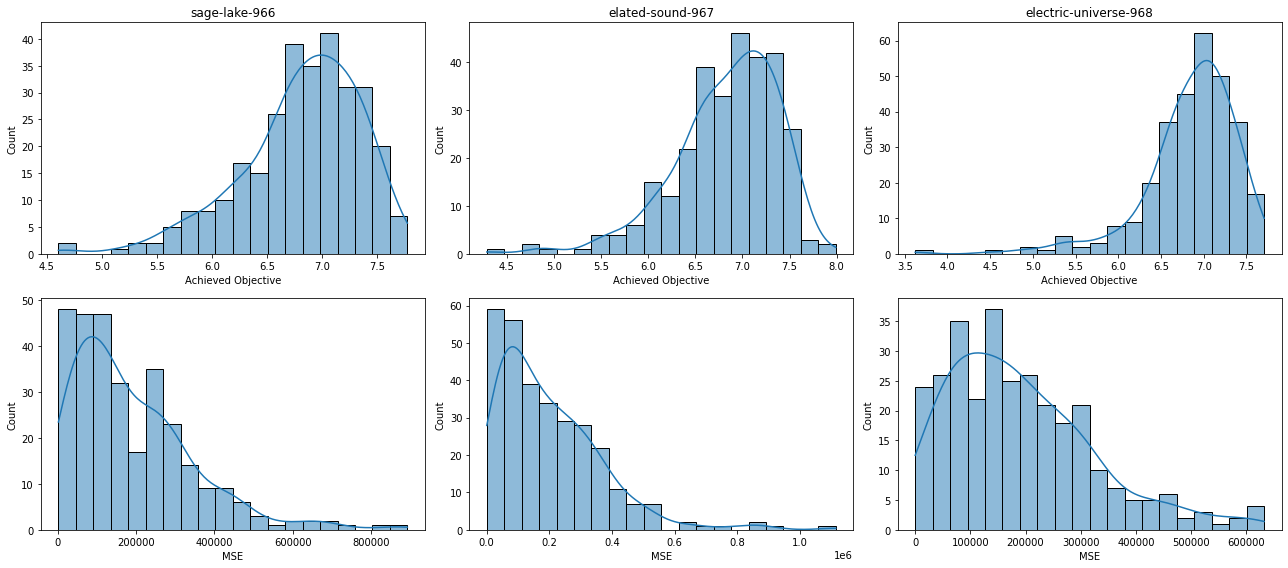

In [32]:
run_evaluation(
    ["sage-lake-966", "elated-sound-967", "electric-universe-968"],
    envargs={"initial": "reset"},
    backendargs={"incoming": "random", "beam_parameters": "direct", "quadrupole_misalignments": "random", "screen_misalignment": "random"}
)

## Training for 6M steps

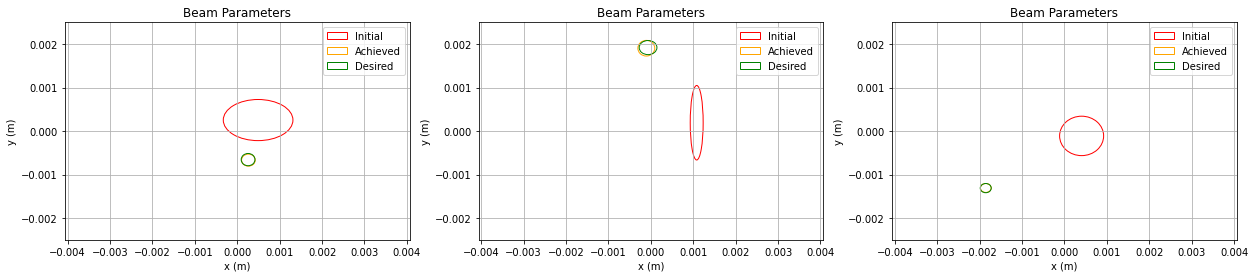

In [33]:
plot_examples(
    "electric-sun-971",
    envargs={"initial": "reset"},
    backendargs={"incoming": "random", "beam_parameters": "direct"}
)

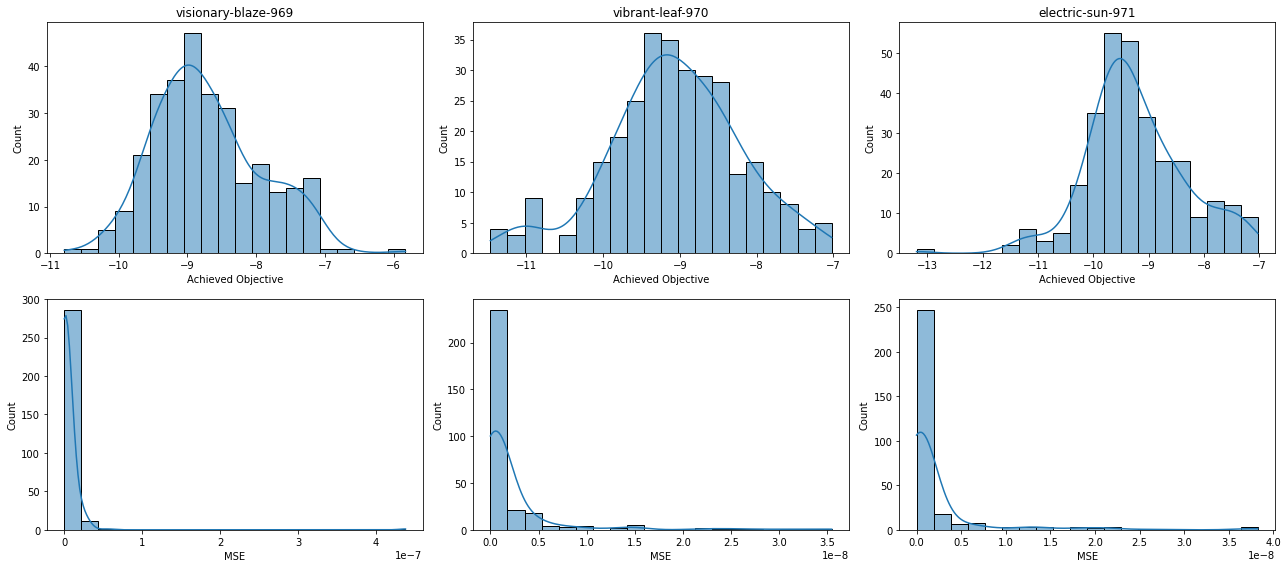

In [34]:
run_evaluation(
    ["visionary-blaze-969", "vibrant-leaf-970", "electric-sun-971"],
    envargs={"initial": "reset"},
    backendargs={"incoming": "random", "beam_parameters": "direct"}
)

## Onestep

In [2]:
run_name = "happy-snowflake-22"
log_dir = f"models/{run_name}"

def make_env():
    env = ARESEAOneStep(
        backend="simulation",
        backendargs={
            "incoming": "random",
            "beam_parameters": "direct"
        },
        initial="reset",
    )
    env = RescaleAction(env, -1, 1)
    return env

env = DummyVecEnv([make_env])
env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
env.training = False
env.norm_reward = False

model = PPO.load(f"{log_dir}/model")

In [ ]:
plt.figure(figsize=(21,4))
for i in range(3):
    observation = env.reset()
    desired = env.unnormalize_obs(observation)[0,-8:-4]
    initial = env.unnormalize_obs(observation)[0,-4:]
    done = False
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, done, info = env.step(action)
    achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]

    print(f"{i}: Initial:", initial)
    print(f"{i}: Achieved:", achieved)
    print(f"{i}: Desired:", desired)
    print(f"{i}: Delta:", desired - achieved)
    print(f"{i}: Objective:", env.unwrapped.envs[0].unwrapped._objective_fn(achieved, desired))

    screen = env.get_attr("backend")[0]._segment.AREABSCR1

    plt.subplot(1, 3, i+1)
    plt.title("Beam Parameters")
    plt.xlim([screen.extent[0], screen.extent[1]])
    plt.ylim([screen.extent[2], screen.extent[3]])
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.grid()
    plt.gca().add_patch(Ellipse((initial[0],initial[1]), initial[2], initial[3], fill=False, color="red", label="Initial"))
    plt.gca().add_patch(Ellipse((achieved[0],achieved[1]), achieved[2], achieved[3], fill=False, color="orange", label="Achieved"))
    plt.gca().add_patch(Ellipse((desired[0],desired[1]), desired[2], desired[3], fill=False, color="green", label="Desired"))
    plt.legend()
plt.show()

Initial: [1.18987896e-03 4.67448274e-05 8.64917454e-04 7.98261708e-04]
Achieved: [-0.00038113  0.00095929  0.00012036  0.00026755]
Desired: [-0.00023998  0.00106667  0.00035142  0.00018446]
Delta: [ 1.41146272e-04  1.07375930e-04  2.31059953e-04 -8.30862553e-05]
Objective: -7.0392156
Initial: [-0.00218474  0.00034821  0.00055311  0.00111559]
Achieved: [1.75145451e-03 1.49393473e-03 1.50694765e-05 4.64820385e-04]
Desired: [1.76080740e-03 1.35491304e-03 8.31791301e-05 4.13363188e-04]
Delta: [ 9.35289555e-06 -1.39021697e-04  6.81096536e-05 -5.14571973e-05]
Objective: -7.855774
Initial: [1.84180982e-03 6.17617106e-05 7.34142838e-04 1.91749620e-03]
Achieved: [-1.04425137e-03  6.80781945e-04  3.92363792e-05  3.46629575e-04]
Desired: [-0.00093773  0.0005029   0.00015291  0.00013073]
Delta: [ 0.00010652 -0.00017788  0.00011367 -0.0002159 ]
Objective: -6.9658732


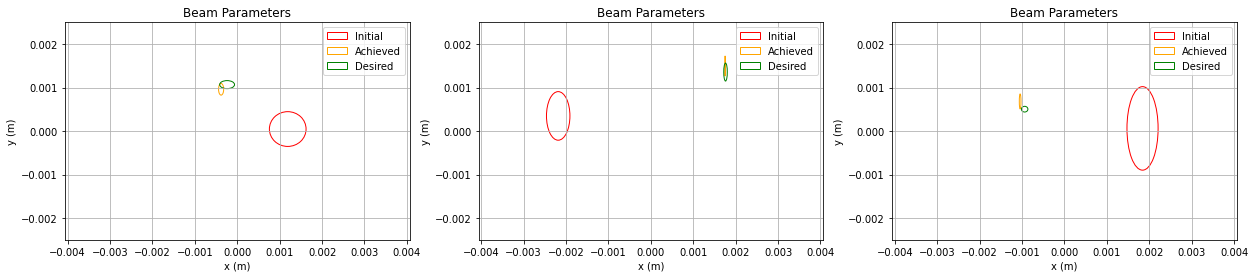

In [8]:
plt.figure(figsize=(21,4))
for i in range(3):
    observation = env.reset()
    desired = env.unnormalize_obs(observation)[0,-8:-4]
    initial = env.unnormalize_obs(observation)[0,-4:]
    action, _ = model.predict(observation, deterministic=True)
    observation, reward, done, info = env.step(action)
    achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]

    print("Initial:", initial)
    print("Achieved:", achieved)
    print("Desired:", desired)
    print("Delta:", desired - achieved)
    print("Objective:", -reward[0])

    screen = env.get_attr("backend")[0]._segment.AREABSCR1

    plt.subplot(1, 3, i+1)
    plt.title("Beam Parameters")
    plt.xlim([screen.extent[0], screen.extent[1]])
    plt.ylim([screen.extent[2], screen.extent[3]])
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.grid()
    plt.gca().add_patch(Ellipse((initial[0],initial[1]), initial[2], initial[3], fill=False, color="red", label="Initial"))
    plt.gca().add_patch(Ellipse((achieved[0],achieved[1]), achieved[2], achieved[3], fill=False, color="orange", label="Achieved"))
    plt.gca().add_patch(Ellipse((desired[0],desired[1]), desired[2], desired[3], fill=False, color="green", label="Desired"))
    plt.legend()
plt.show()

In [9]:
def evaluate(run_name, n=100):
    log_dir = f"models/{run_name}"

    def make_env():
        env = ARESEAOneStep(
            backend="simulation",
            backendargs={
                "incoming": "random",
                "beam_parameters": "direct"
            },
            initial="reset",
        )
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = PPO.load(f"{log_dir}/model")

    objectives = []
    for _ in range(n):
        observation = env.reset()
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, done, info = env.step(action)
        objectives.append(-reward[0])
    
    return objectives

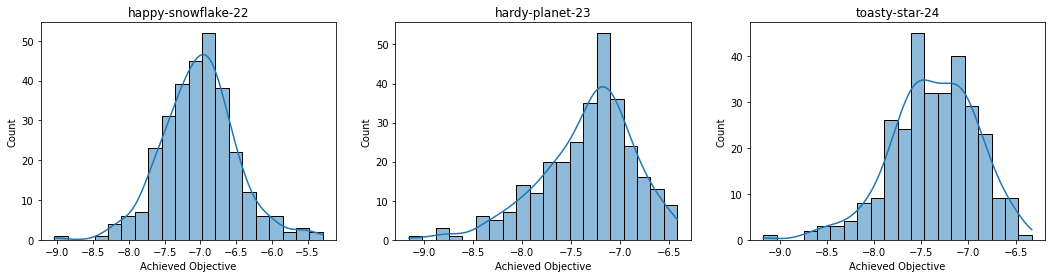

In [10]:
run_names = ["happy-snowflake-22", "hardy-planet-23", "toasty-star-24"]
results = [evaluate(run_name, n=300) for run_name in run_names]

plt.figure(figsize=(18,4))
for i, (run_name, result) in enumerate(zip(run_names, results)):
    plt.subplot(1, len(run_names), i+1)
    plt.title(run_name)
    sns.histplot(result, bins=20, kde=True)
    plt.xlabel("Achieved Objective")
plt.show()